In [2]:
import pandas as pd
import numpy as np
import sys
import os

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import plotly #Plotting

#GLM == General Linear Models
import scipy
import statsmodels

#Find the utils Directory
sys.path.append(os.path.abspath("../../"))
from src.utils.ConvertTextToCsv import TextToCsv

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
df_txt = pd.read_csv("data_mrna_seq_v2_rsem.txt", header=None)
print(df_txt)

                                                       0
0      Hugo_Symbol\tEntrez_Gene_Id\tTCGA-A1-A0SB-01\t...
1      UBE2Q2P2\t100134869\t14.3935\t11.3241\t4.4426\...
2      HMGB1P1\t10357\t116.3870\t60.2630\t153.1452\t1...
3      LOC155060\t155060\t279.7612\t83.6986\t74.7018\...
4      RNU12-2P\t26823\t0.4505\t0.3308\t0.0000\t0.000...
...                                                  ...
20436  ZYX\t7791\t6186.7327\t3559.6725\t3007.8157\t53...
20437  ZZEF1\t23140\t1931.2986\t1278.9678\t926.3677\t...
20438  ZZZ3\t26009\t1436.1978\t1195.6000\t1075.4422\t...
20439  TPTEP1\t387590\t552.3144\t86.0144\t866.1456\t5...
20440  AKR1C6P\t389932\t0.0000\t0.0000\t0.0000\t0.856...

[20441 rows x 1 columns]


In [4]:
df_csv = TextToCsv("data_mrna_seq_v2_rsem.txt")
print(df_csv.columns)

Shape of the CSV: (20440, 819)
Index(['Hugo_Symbol', 'Entrez_Gene_Id', 'TCGA-A1-A0SB-01', 'TCGA-A1-A0SD-01',
       'TCGA-A1-A0SE-01', 'TCGA-A1-A0SF-01', 'TCGA-A1-A0SH-01',
       'TCGA-A1-A0SI-01', 'TCGA-A1-A0SJ-01', 'TCGA-A1-A0SK-01',
       ...
       'TCGA-LL-A5YM-01', 'TCGA-LL-A5YN-01', 'TCGA-LL-A5YO-01',
       'TCGA-LL-A5YP-01', 'TCGA-LQ-A4E4-01', 'TCGA-MS-A51U-01',
       'TCGA-OL-A66H-01', 'TCGA-OL-A66I-01', 'TCGA-OL-A66J-01',
       'TCGA-OL-A66K-01'],
      dtype='object', length=819)


In [8]:
df_counts = df_csv.drop(columns=["Hugo_Symbol", "Entrez_Gene_Id"])

df_counts = df_counts.T

df_counts = df_counts.astype(int)




Eliminate The values that are 0 in the rows

In [9]:
#Filtrate
df_counts = df_counts.loc[:, ~(df_counts == 0).any(axis=0)]
#df_counts = df_counts.loc[:, (df_counts > 0).sum(axis=0) >= 2] #Preguntar Manuel
print(df_counts.head())  




                 1      2      14     17     19     22     24     25     \
TCGA-A1-A0SB-01    116    279     43    392     49     37  31626    337   
TCGA-A1-A0SD-01     60     83    226    271    142     66  23793    377   
TCGA-A1-A0SE-01    153     74    299    476    192     70  15728    266   
TCGA-A1-A0SF-01    141    314    276    743    326    161  15583    441   
TCGA-A1-A0SH-01     79     95    126    353    180    130  13997    348   

                 28     30     ...  20427  20428  20429  20430  20431  20432  \
TCGA-A1-A0SB-01    711   2184  ...    614    474    321     95    519   1415   
TCGA-A1-A0SD-01    527    784  ...    367    372    648     96    578   1225   
TCGA-A1-A0SE-01    636    831  ...    367    441    810     95    726   1018   
TCGA-A1-A0SF-01   1005    442  ...    495    267    676     74    533   1053   
TCGA-A1-A0SH-01    524    820  ...    301    402    346     87    581    801   

                 20434  20435  20436  20437  
TCGA-A1-A0SB-01   1364

BoxPlots for the mRNA-Seq

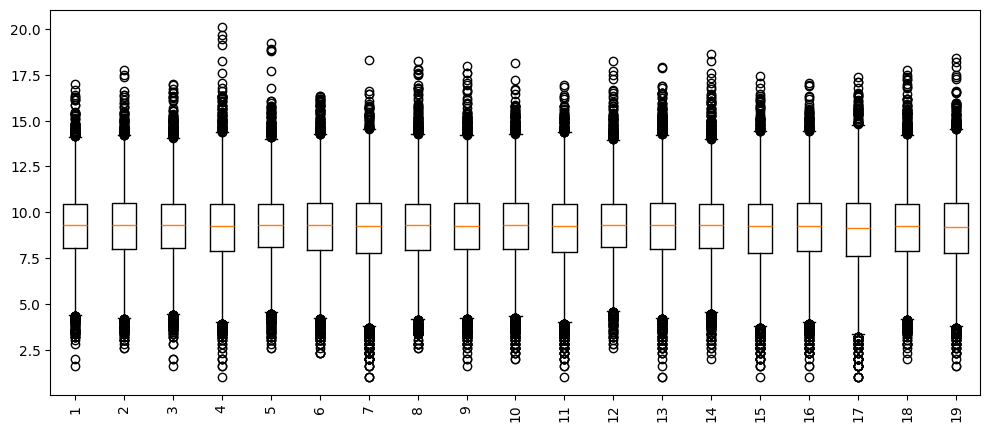

In [10]:

plt.figure(figsize=(12,5))
plt.boxplot(np.log2(df_counts[1:20].T + 1))  # transpose
plt.xticks(rotation=90)
plt.show()


In [11]:

#N of Cpu
inference = DefaultInference(n_cpus=2)
metadata = pd.DataFrame(index=df_counts.index)
print(metadata)

Empty DataFrame
Columns: []
Index: [TCGA-A1-A0SB-01, TCGA-A1-A0SD-01, TCGA-A1-A0SE-01, TCGA-A1-A0SF-01, TCGA-A1-A0SH-01, TCGA-A1-A0SI-01, TCGA-A1-A0SJ-01, TCGA-A1-A0SK-01, TCGA-A1-A0SM-01, TCGA-A1-A0SN-01, TCGA-A1-A0SP-01, TCGA-A1-A0SQ-01, TCGA-A2-A04N-01, TCGA-A2-A04P-01, TCGA-A2-A04Q-01, TCGA-A2-A04R-01, TCGA-A2-A04T-01, TCGA-A2-A04U-01, TCGA-A2-A04V-01, TCGA-A2-A04W-01, TCGA-A2-A04X-01, TCGA-A2-A04Y-01, TCGA-A2-A0CK-01, TCGA-A2-A0CL-01, TCGA-A2-A0CM-01, TCGA-A2-A0CO-01, TCGA-A2-A0CP-01, TCGA-A2-A0CQ-01, TCGA-A2-A0CR-01, TCGA-A2-A0CS-01, TCGA-A2-A0CT-01, TCGA-A2-A0CU-01, TCGA-A2-A0CV-01, TCGA-A2-A0CW-01, TCGA-A2-A0D0-01, TCGA-A2-A0D2-01, TCGA-A2-A0D3-01, TCGA-A2-A0D4-01, TCGA-A2-A0EM-01, TCGA-A2-A0EN-01, TCGA-A2-A0EO-01, TCGA-A2-A0EP-01, TCGA-A2-A0EQ-01, TCGA-A2-A0ER-01, TCGA-A2-A0ES-01, TCGA-A2-A0ET-01, TCGA-A2-A0EU-01, TCGA-A2-A0EV-01, TCGA-A2-A0EW-01, TCGA-A2-A0EX-01, TCGA-A2-A0EY-01, TCGA-A2-A0ST-01, TCGA-A2-A0SU-01, TCGA-A2-A0SV-01, TCGA-A2-A0SW-01, TCGA-A2-A0SX-01, TCGA-A2-A0SY

In [ ]:
deseqDataset = DeseqDataSet(
    counts=df_counts,
    metadata=metadata,
    design="~condition",
    refit_cooks=True,
    inference=inference
)

deseqDataset.deseq2()